In [1]:
import torch
import numpy as np
import os
from ShapeVVE.DataLoader.loadDataFromAfrr import get_UEA_dataset

# 1.加载数据集
DATASET_PATH = "../../../data_files/Multivariate2018_arff/Multivariate_arff"
print(os.path.exists(DATASET_PATH))
x_train, y_train, x_val, y_val, x_test, y_test=get_UEA_dataset(DATASET_PATH,"BasicMotions")
print(f"x_train: {x_train.shape}, y_train: {y_train.shape}, x_val: {x_val.shape}, y_val: {y_val.shape}, x_test: {x_test.shape}, y_test: {y_test.shape}")

n_classes = len(np.unique(y_train))
in_channels=len(x_train[0])

x_train = torch.from_numpy(x_train)
x_val = torch.from_numpy(x_val)
x_test = torch.from_numpy(x_test)
y_train = torch.from_numpy(y_train)
y_val = torch.from_numpy(y_val)
y_test = torch.from_numpy(y_test)

print(f'n_classes: {n_classes}')

True
Shapes - Train: (40, 6, 100), Val: (8, 6, 100), Test: (32, 6, 100)
x_train: (40, 6, 100), y_train: (40,), x_val: (8, 6, 100), y_val: (8,), x_test: (32, 6, 100), y_test: (32,)
n_classes: 4


Test Accuracy: 1.0000
Shapelets shape: torch.Size([20, 6, 10])
Linear layer weights shape: torch.Size([4, 20])
Linear layer biases shape: torch.Size([4])


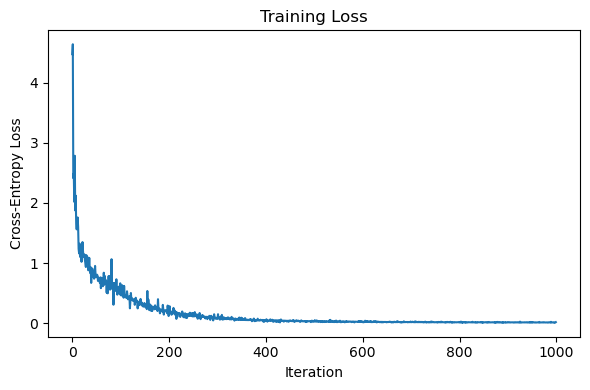

In [2]:
from ShapeVVE.PredictorModel.LearningShapeletsOrigin import LearningShapelets
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
from torch.optim import Adam

# 编码标签
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# 定义模型参数
shapelets_size_and_len = {5: 10,  10: 10}  # 3个block，分别有5个长度为10、20、30的shapelets
in_channels = x_train.shape[1]
num_classes = len(np.unique(y_train_encoded))
dist_measure = 'euclidean'  # 可以选择 'euclidean', 'cross-correlation', 或 'cosine'

model=LearningShapelets(
    shapelets_size_and_len=shapelets_size_and_len,  # 增加shapelet数量
    loss_func=nn.CrossEntropyLoss(),
    in_channels=in_channels,  # 确保与数据实际通道数一致
    num_classes=num_classes,
    dist_measure='euclidean',
    verbose=1,
    to_cuda=torch.cuda.is_available(),
    # k=4,           # 增大最近邻数量
    # l1=0.01,        # 降低距离损失权重
    # l2=0.001,        # 降低相似性损失权重
)

# 使用更强的优化器
optimizer = Adam(model.model.parameters(), lr=0.01, weight_decay=1e-4)
model.set_optimizer(optimizer)

# 训练模型
epochs = 500
batch_size = 32
losses = model.fit(
    x_train,
    y_train_encoded,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True
)

# 在测试集上评估
model.model.eval()  # 设置模型为评估模式
y_pred = model.predict(x_test)

# 计算准确率
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# 获取shapelets
shapelets = model.get_shapelets()
print(f"Shapelets shape: {shapelets.shape}")

# 获取线性层权重
weights, biases = model.get_weights_linear_layer()
print(f"Linear layer weights shape: {weights.shape}")
print(f"Linear layer biases shape: {biases.shape}")

# 可视化训练损失
import matplotlib.pyplot as plt

if isinstance(losses, tuple):
    # 如果有多个损失（使用正则化时）
    losses_ce, losses_dist, losses_sim = losses
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.plot(losses_ce)
    plt.title('Cross-Entropy Loss')
    plt.xlabel('Iteration')

    plt.subplot(1, 3, 2)
    plt.plot(losses_dist)
    plt.title('Distance Loss')
    plt.xlabel('Iteration')

    plt.subplot(1, 3, 3)
    plt.plot(losses_sim)
    plt.title('Similarity Loss')
    plt.xlabel('Iteration')

else:
    # 只有交叉熵损失
    plt.figure(figsize=(6, 4))
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Cross-Entropy Loss')

plt.tight_layout()
plt.show()